In [7]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm
from ksvd import ApproximateKSVD
from IPython.display import HTML, Video
import numpy as np

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Denoising with dictionary-based K-SVD

ℹ️ ℹ️ This notebook requires the samples of OABF dataset in the `dataset/sample/motion_corrected` folder generated with [1.1.1-Visualize_OABF_Dataset](../1-eda/1.1.1-Visualize_OABF_Dataset.ipynb).

In [2]:
astro_x_path = DATASETS["oabf_astro"] / "x.tiff"
astro_y_path = DATASETS["oabf_astro"] / "y.tiff"

vpm_x_path = DATASETS["oabf_vpm"] / "x.tiff"
vpm_y_path = DATASETS["oabf_vpm"] / "y.tiff"

resonant_neuro_x_path = DATASETS["oabf_resonant_neuro"] / "x.tiff"

In [ ]:
# 5s
astro_x, astro_y = Recording(astro_x_path), Recording(astro_y_path)
vpm_x, vpm_y = Recording(vpm_x_path), Recording(vpm_y_path)
resonant_neuro_x = Recording(resonant_neuro_x_path)

## K-SVD denoising

### 1. Running BM3D

In [ ]:
# 7.7s/frame (components=52)
ksvd = ApproximateKSVD(n_components=52)
k_svd = []
for i in tqdm(range(2)):
    dictionary = ksvd.fit(astro_x[i].np).components_
    gamma = ksvd.transform(astro_x[i].np)
    k_svd.append(gamma.dot(dictionary))
k_svd = np.stack(k_svd)

### 2. Computing evaluation metrics

In [13]:
psnr=peak_signal_noise_ratio(astro_y.np[0], k_svd[0], data_range=1)
ssim=structural_similarity(astro_y.np[0], k_svd[0], data_range=1)
cprint('PSNR','red:(DeepCAD - K-SVD)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - K-SVD)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - K-SVD) --> 24.05dB
SSIM (DeepCAD - K-SVD) --> 0.353


### 3. Visually comparing results

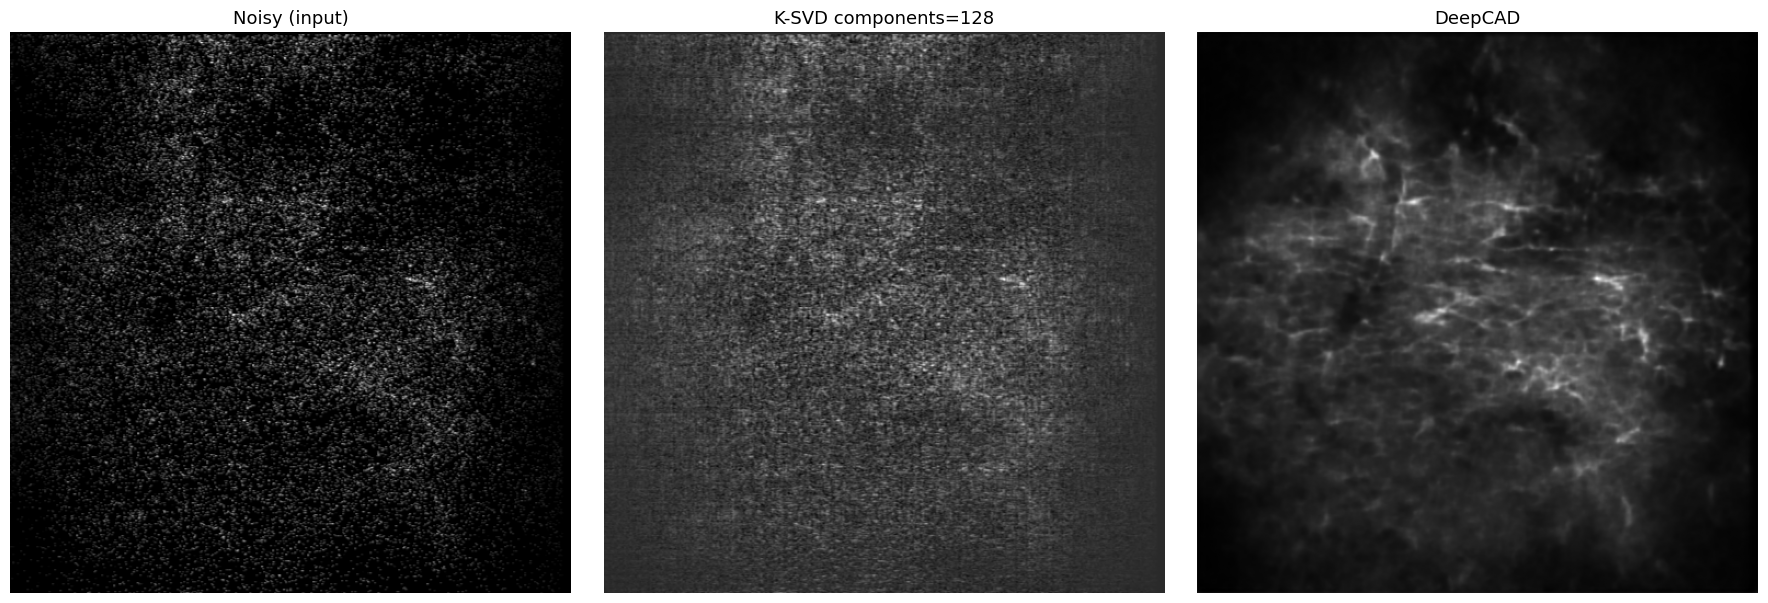

In [14]:
imshow(
    {
        "Noisy (input)": astro_x.np[0],
        "K-SVD components=128": k_svd[0],
        "DeepCAD": astro_y.np[0],
    },
    size=6,
    cmap="grey",
)

K-SVD is meant to be used with natural images. It does not perform well with neuroscience images.
Classic methods are not tailored to Poisson statistic.